In [ ]:
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

from pathlib import Path

%matplotlib inline

@jit(nopython=True)
def compute_constellation_map_naive(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (naive implementation)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    # spectrogram dimensions
    if Y.ndim > 1:
        (K, N) = Y.shape
    else:
        K = Y.shape[0]
        N = 1
    Cmap = np.zeros((K, N), dtype=np.bool8)

    # loop over spectrogram
    for k in range(K):
        f1 = max(k - dist_freq, 0)
        f2 = min(k + dist_freq + 1, K)
        for n in range(N):
            t1 = max(n - dist_time, 0)
            t2 = min(n + dist_time + 1, N)
            curr_mag = Y[k, n]
            curr_rect = Y[f1:f2, t1:t2]
            c_max = np.max(curr_rect)
            if ((curr_mag == c_max) and (curr_mag > thresh)):
                Cmap[k, n] = True
    return Cmap

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn_wav, sr=Fs) #changed
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann') #changed
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[1] #changed 0 -> 1
    Y = np.abs(X[:bin_max, :frame_max])


    return Y





In [42]:
folder_name = "original" # original / coding / noise / mobile    
index = 10 #0-19           

files = sorted((Path("data") / folder_name).iterdir())
fn = files[index]
print(fn.name)

205321.low.mp3


9.984580498866213


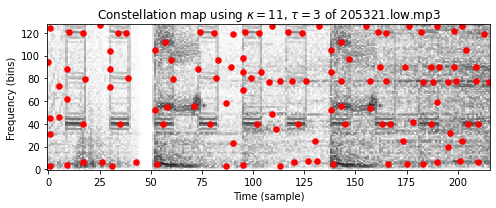

In [41]:

Y = compute_spectrogram(fn)

dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 3   # tau: neighborhood in time direction
title=r'Constellation map using $\kappa=%d$, $\tau=%d$ of %s' % (dist_freq, dist_time, fn.name)
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), 
                                     color='r', s=30, title=title)